In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau


sns.set(style='white', context='notebook', palette='deep')

Using Theano backend.
C:\Users\USER\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\USER\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\USER\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\USER\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: Fu

In [12]:
train = pd.read_csv("./train.csv")
test = pd.read_csv("./eval.csv")

C:\Users\USER\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


13    555
15    554
12    549
11    545
14    544
10    513
1     432
5     431
4     431
7     430
2     430
9     430
3     429
6     429
8     429
0     426
Name: 0, dtype: int64

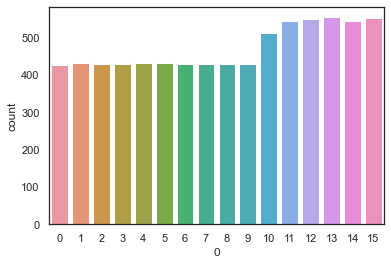

In [13]:
#train
Y_train = train['0']

# Drop 'label' column
X_train = train.drop(train.columns[0],axis = 1)

# free some space
del train 

g = sns.countplot(Y_train)

Y_train.value_counts()

C:\Users\USER\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


15    80
13    80
12    80
14    78
11    78
10    76
1     55
9     54
8     54
7     54
5     54
4     54
3     54
2     54
6     53
0     52
Name: 0, dtype: int64

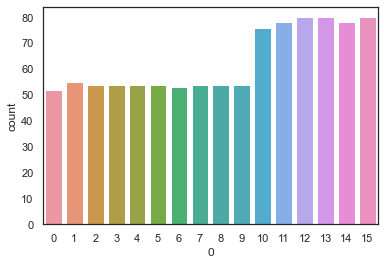

In [14]:
#test
Y_test = test['0']

# Drop 'label' column
X_test = test.drop(test.columns[0],axis = 1)

# free some space
del test

g = sns.countplot(Y_test)

Y_test.value_counts()

In [15]:
# Check the data
X_train.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [16]:
X_test.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [17]:
# Normalize the data
X_train = X_train / 255.0
X_test = X_test / 255.0

In [18]:
# Reshape image in 3 dimensions (height = 28px, width = 28px , canal = 1)
X_train = X_train.values.reshape(-1,28,28,1)
X_test = X_test.values.reshape(-1,28,28,1)

In [19]:
# Encode labels to one hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
Y_train = to_categorical(Y_train, num_classes = 16)

In [20]:
# Set the random seed
random_seed = 2

In [21]:
# Split the train and the validation set for the fitting
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state=random_seed)

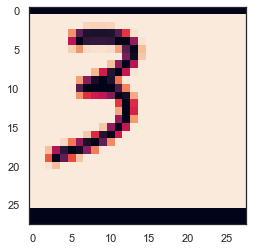

In [22]:
# Some examples
g = plt.imshow(X_train[5][:,:,0])

In [28]:
# Set the CNN model 
# my CNN architechture is In -> [[Conv2D->relu]*2 -> MaxPool2D -> Dropout]*2 -> Flatten -> Dense -> Dropout -> Out

model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(16, activation = "softmax"))

In [29]:
# Define the optimizer
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

In [30]:
# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [31]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [32]:
epochs = 30 # Turn epochs to 30 to get 0.9967 accuracy
batch_size = 86

In [33]:
# Without data augmentation i obtained an accuracy of 0.98114
#history = model.fit(X_train, Y_train, batch_size = batch_size, epochs = epochs, 
#          validation_data = (X_val, Y_val), verbose = 2)

In [34]:
# With data augmentation to prevent overfitting (accuracy 0.99286)

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)

In [35]:
# Fit the model
history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])

Epoch 1/30
 - 38s - loss: 2.6624 - accuracy: 0.1218 - val_loss: 1.8805 - val_accuracy: 0.4669
Epoch 2/30


C:\Users\USER\anaconda3\lib\site-packages\keras\callbacks\callbacks.py:1042: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


 - 43s - loss: 1.8791 - accuracy: 0.4110 - val_loss: 1.0930 - val_accuracy: 0.7011
Epoch 3/30
 - 49s - loss: 1.3184 - accuracy: 0.5894 - val_loss: 0.7091 - val_accuracy: 0.7923
Epoch 4/30
 - 53s - loss: 0.9525 - accuracy: 0.7105 - val_loss: 0.4730 - val_accuracy: 0.8571
Epoch 5/30
 - 62s - loss: 0.8113 - accuracy: 0.7590 - val_loss: 0.4884 - val_accuracy: 0.8492
Epoch 6/30
 - 47s - loss: 0.6590 - accuracy: 0.8021 - val_loss: 0.3195 - val_accuracy: 0.9034
Epoch 7/30
 - 47s - loss: 0.5323 - accuracy: 0.8408 - val_loss: 0.2775 - val_accuracy: 0.9167
Epoch 8/30
 - 47s - loss: 0.4732 - accuracy: 0.8570 - val_loss: 0.2379 - val_accuracy: 0.9299
Epoch 9/30
 - 47s - loss: 0.4267 - accuracy: 0.8762 - val_loss: 0.2122 - val_accuracy: 0.9444
Epoch 10/30
 - 48s - loss: 0.4074 - accuracy: 0.8822 - val_loss: 0.2066 - val_accuracy: 0.9444
Epoch 11/30
 - 48s - loss: 0.3615 - accuracy: 0.8922 - val_loss: 0.1785 - val_accuracy: 0.9497
Epoch 12/30
 - 48s - loss: 0.3020 - accuracy: 0.9142 - val_loss: 0.13

In [37]:
#save model
model.save('./train_model_30epochs')